# News Analysis with LLM (Gemini)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [2]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [3]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [4]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("../../DataCollection/Data/Trending_News/2025-05-28_22-31-36.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-28,10:26,TSX up slightly ahead of NVIDIA earnings By In...,Investing.com -- Canada’s main stock index was...,https://www.investing.com/news/stock-market-ne...
1,2025-05-28,09:58,This is what matters most for today’s Nvidia e...,Investing.com -- As Nvidia (NASDAQ: ) gears up...,https://www.investing.com/news/stock-market-ne...
2,2025-05-28,09:36,Goldman Sachs makes the strategic case for gol...,Investing.com -- Goldman Sachs made the case f...,https://www.investing.com/news/commodities-new...
3,2025-05-28,09:22,Tempus AI stock sinks following Spruce Point s...,Investing.com -- Shares of Tempus AI (NASDAQ: ...,https://www.investing.com/news/stock-market-ne...
4,2025-05-28,09:17,"GameStop pulls the trigger, discloses $513 mil...",Investing.com -- GameStop Corp (NYSE: ) shares...,https://www.investing.com/news/stock-market-ne...


In [7]:
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [8]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [9]:
print(df.head())

  publish_date publish_time  \
0   2025-05-28        10:26   
1   2025-05-28        09:58   
2   2025-05-28        09:36   
3   2025-05-28        09:22   
4   2025-05-28        09:17   

                                               title  \
0  TSX up slightly ahead of NVIDIA earnings By In...   
1  This is what matters most for today’s Nvidia e...   
2  Goldman Sachs makes the strategic case for gol...   
3  Tempus AI stock sinks following Spruce Point s...   
4  GameStop pulls the trigger, discloses $513 mil...   

                                           body_text  \
0  Investing.com -- Canada’s main stock index was...   
1  Investing.com -- As Nvidia (NASDAQ: ) gears up...   
2  Investing.com -- Goldman Sachs made the case f...   
3  Investing.com -- Shares of Tempus AI (NASDAQ: ...   
4  Investing.com -- GameStop Corp (NYSE: ) shares...   

                                                 url  
0  https://www.investing.com/news/stock-market-ne...  
1  https://www.investing.com/

In [10]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting:   0%|          | 0/20 [00:00<?, ?it/s]

Prompting: 100%|██████████| 20/20 [01:52<00:00,  5.64s/it]


In [11]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [12]:
print(df["title"][2],'\n\n',predicted[2])

Goldman Sachs makes the strategic case for gold and oil in long-run portfolios By Investing.com 

 **Sentiment:**
Neutral

**Summary:**
Goldman Sachs recommends long-term investors strategically allocate more to gold and less to oil over a five-year horizon, viewing them as hedges against inflation and systemic risks. They cite risks to US institutional credibility and central bank demand for overweighting gold, while near-term supply dynamics support underweighting oil, though long-term supply risks warrant a limited allocation.

**Reasoning for Sentiment:**
The article objectively reports on Goldman Sachs' analysis and portfolio recommendations for gold and oil. It presents their reasoning and findings without expressing any editorial opinion or bias, making it purely informational.

**Importance to Stock news:**
3

**Reasoning for Importance:**
The article is moderately important as it reports on portfolio allocation recommendations from a major investment bank, which can influence 

In [13]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [14]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
0,2025-05-28,TSX up slightly ahead of NVIDIA earnings By In...,Neutral,5,"The Canadian TSX index saw a slight gain, whil..."
1,2025-05-28,This is what matters most for today’s Nvidia e...,Neutral,5,Mizuho analysts indicate that investors are pr...
3,2025-05-28,Tempus AI stock sinks following Spruce Point s...,Negative,5,Tempus AI stock fell 4% after a short-seller r...
4,2025-05-28,"GameStop pulls the trigger, discloses $513 mil...",Positive,5,"GameStop has invested $513 million in Bitcoin,..."
6,2025-05-28,Wells Fargo: Time to trim U.S. small caps afte...,Negative,5,Wells Fargo analysts recommend investors reduc...
7,2025-05-28,Barclays sees upside in stocks as re-risking s...,Positive,5,Barclays maintains a positive outlook for equi...
8,2025-05-28,"Nvidia earnings, new Stellantis CEO, Japanese ...",Neutral,5,The article provides a market overview focusin...
9,2025-05-28,sell Nvidia ahead of earnings? Here’s what our...,Neutral,5,The article discusses the anticipation surroun...
10,2025-05-28,Bitcoin price today: slips to $108.5k but stay...,Positive,5,Bitcoin experienced a slight price dip to $108...
11,2025-05-27,Asia stocks rise tracking Wall St gains; Tech ...,Positive,5,"Most Asian stocks rose, tracking Wall Street g..."


In [15]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [16]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

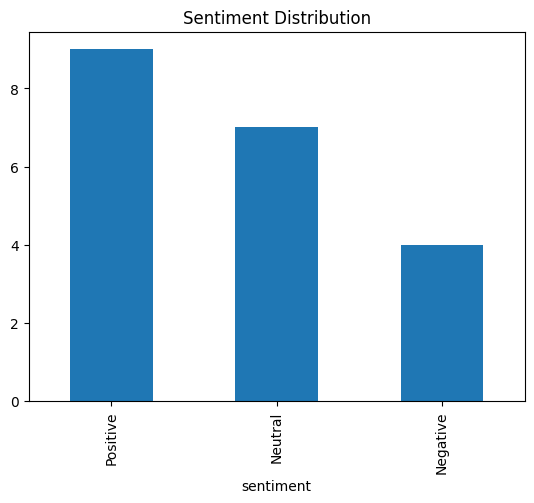

In [17]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

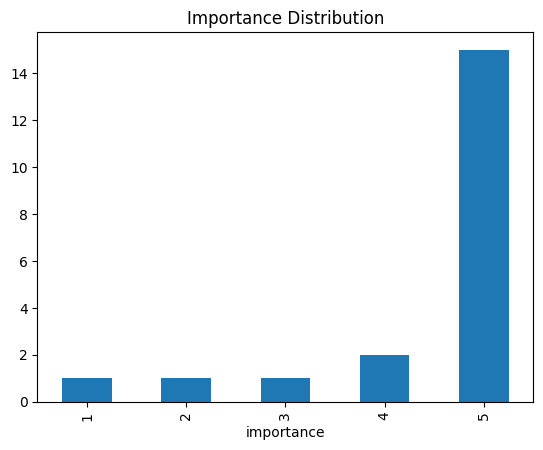

In [18]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [19]:
TICKER=current_stock

In [20]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [21]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [22]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for news: 0.29


In [23]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini/Gemini_{TICKER}_{date_time}.csv", index=False)